In [34]:
import xarray as xr
import numpy as np
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import pandas as pd

np.set_printoptions(threshold=np.inf)
dirpath = '/local/data/soccom/SOCCOM_LoResQC_LIAR_05May2021_netcdf/'
f_4180 = xr.open_dataset(dirpath + '5904180QC.nc')
f_4180

<xarray.Dataset>
Dimensions:              (NPARAMETER: 36, N_LEVELS: 69, N_PROF: 217)
Dimensions without coordinates: NPARAMETER, N_LEVELS, N_PROF
Data variables: (12/51)
    Cruise               |S11 ...
    Station              (N_PROF) int32 ...
    Lon                  (N_PROF) float64 ...
    Lat                  (N_PROF) float64 ...
    Lat_QF               (N_PROF) |S1 ...
    Lat_QFA              (N_PROF) float64 ...
    ...                   ...
    Type                 |S1 ...
    mon_day_yr           (N_PROF) |S10 ...
    hh_mm                (N_PROF) |S5 ...
    Parameters           (NPARAMETER) |S19 ...
    JULD                 (N_PROF) datetime64[ns] ...
    REFERENCE_DATE_TIME  object ...
Attributes:
    Comments:  \n//0\n//<Encoding>UTF-8</Encoding>\n//File updated on 05/01/2...

In [8]:
#print(f_4180.Oxygen.values*100/f_4180.OxygenSat.values)

In [12]:
def set_oxygen_var(fl):
    oxygen = fl.Oxygen.transpose().values
    oxygen_qf = fl.Oxygen_QFA.transpose().values
    oxygen_qf = oxygen_qf == 0
    oxygen[~oxygen_qf] = np.nan
    return oxygen
def set_oxygen_sat_var(fl):
    oxygen = fl.OxygenSat.transpose().values
    oxygen_qf = fl.OxygenSat_QFA.transpose().values
    oxygen_qf = oxygen_qf == 0
    oxygen[~oxygen_qf] = np.nan
    return oxygen
def set_nitrate_var(fl):
    nitrate = fl.Nitrate.transpose().values
    nitr_qf = fl.Nitrate_QFA.transpose().values
    nitr_qf = np.logical_or(nitr_qf ==0, nitr_qf == 4)
    nitrate[~nitr_qf] = np.nan
    return nitrate

# O2 Budget for One Float, One Year

In [40]:

np.set_printoptions(suppress=True)
time = f_4180.JULD.values
dates = pd.to_datetime(time).year    
dayofyear = f_4180.JULD.dt.dayofyear        

#calculate O2sat
o2 = set_oxygen_var(f_4180)
o2 = o2[:,dates==2017]
oxygenSat = set_oxygen_sat_var(f_4180)
oxygenSat = oxygenSat[:,dates==2017]
o2sat = (o2*(oxygenSat/100))

#calculate AOU 
aou = o2sat - o2

#calculate ∆AOU
#dim: depth (69) x profiles/time (217)
aou_am = np.nanmean(aou, axis=1)
d_aou = aou-aou_am[:,None]

#calculate ∆O2
o2_am = np.nanmean(o2, axis=1)
d_o2 = o2-o2_am[:,None]

#calculate ∆NO3
no3 = set_nitrate_var(f_4180)
no3 = no3[:,dates==2017]

no3_am = np.nanmean(no3, axis=1)
d_no3 = no3-no3_am[:,None]

#calculate ∆O2sol
d_o2sol = d_o2 + d_aou

#calculate ∆O2mix + ∆O2bio
r = -170/16
d_o2mixbio = d_o2 + r*d_no3

#calculate ∆O2gasex
d_o2gasex = np.negative(d_aou) - r*d_no3



<ipython-input-40-b4f68239d754>:18: RuntimeWarning: Mean of empty slice
  aou_am = np.nanmean(aou, axis=1)
<ipython-input-40-b4f68239d754>:22: RuntimeWarning: Mean of empty slice
  o2_am = np.nanmean(o2, axis=1)
<ipython-input-40-b4f68239d754>:29: RuntimeWarning: Mean of empty slice
  no3_am = np.nanmean(no3, axis=1)


In [31]:
def get_mld_rho(fl, interp):
    density = fl.Sigma_theta.transpose().values
    if interp: 
        density = interp_var(density, fl)
    density = np.flip(density, 0)
    #density=density.reshape(1,(dim[0]*dim[1]), order='F')
    depth = fl.Depth.transpose().values
    if interp: 
        depth = interp_var(depth, fl)
    depth = np.flip(depth, 0)
        
    #depth=depth.reshape(1,(dim[0]*dim[1]), order='F')
    rhocrit = 0.02
    density[np.isnan(depth)] = float("nan")
    depth[np.isnan(density)] = float("nan")
    d10 = np.absolute(depth-10)
    dref = np.empty((1, np.size(density, 1)))
    dref[:] = np.NaN
    mld = np.empty((1,np.size(density, 1)))
    mld[:] = np.NaN
    imld = np.empty((1,np.size(density, 1))) 
    imld[:] = np.NaN
    for ii in range(np.size(density,1)):
        idx = (d10[:, ii]==np.nanmin(d10[:,ii], axis=0)).argmax()
        dref[0,ii]=depth[idx,ii]
        if (idx.size != 0):
            drho10 = density[idx, ii]
            drho10 = np.absolute(density[:,ii] - drho10);
            drho10[0:idx] = np.NaN;
            idx = (drho10>=rhocrit).argmax()
            if (idx.size == 0):
                imld[0, ii] = np.NaN
                mld[0, ii] = np.Nan
            else:
                imld[0,ii]=idx;
                mld[0,ii]=depth[idx,ii]
        else:
            imld[0, ii] = np.NaN
            mld[0, ii] = np.Nan
    imld[mld>900]=np.NaN;
    mld[mld>900]=np.NaN;
    imld = imld.flatten()
    mld = mld.flatten()
    end = len(depth)
    depth_cat = np.stack((depth[0:end-1,:],depth[1:end,:]),axis=2);
    dpth_mid=np.nanmean(depth_cat, axis=2)
    depth2 = np.vstack((depth[0,:],dpth_mid,depth[end-1,:]))
    thickn=np.diff(depth2,axis=0);

    return mld, imld, thickn


<ipython-input-31-72fe2002e3d6>:46: RuntimeWarning: Mean of empty slice
  dpth_mid=np.nanmean(depth_cat, axis=2)
<ipython-input-42-40c41fafae77>:17: RuntimeWarning: invalid value encountered in double_scalars
  avg_var[i] = np.nansum(variable[0:int(imld[i]),i]*thickn[0:int(imld[i]),i])/np.nansum(thickn[0:int(imld[i]),i])
<ipython-input-42-40c41fafae77>:17: RuntimeWarning: invalid value encountered in double_scalars
  avg_var[i] = np.nansum(variable[0:int(imld[i]),i]*thickn[0:int(imld[i]),i])/np.nansum(thickn[0:int(imld[i]),i])


[None, None, None, None]

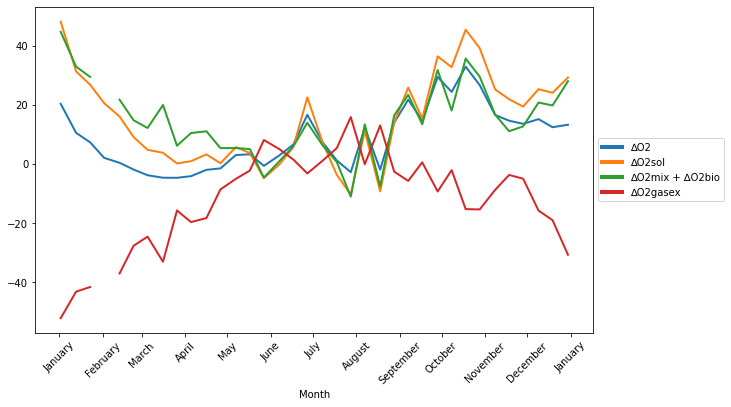

In [42]:
mld, imld, thickn = get_mld_rho(f_4180, False)
variables = [d_o2, d_o2sol, d_o2mixbio, d_o2gasex]
varNames = ['∆O2', '∆O2sol', '∆O2mix + ∆O2bio', '∆O2gasex']

#temporary (just for one yr)
mld = mld[dates==2017]
imld = imld[dates==2017]
thickn = thickn[:,dates==2017]

fig, ax = plt.subplots(figsize=(10,6))
for var in range(len(variables)): 
    variable = np.flip(variables[var], 0)
    variable[variable==0] = np.nan
    thickn[np.isnan(variable)] = np.nan
    avg_var = np.empty((1,np.size(variable, 1))).flatten()
    for i in range(len(imld)):
        avg_var[i] = np.nansum(variable[0:int(imld[i]),i]*thickn[0:int(imld[i]),i])/np.nansum(thickn[0:int(imld[i]),i])
    ax.plot(dayofyear.values[dates==2017], avg_var, linewidth=2, label=varNames[var])
date_form = DateFormatter("%B") # %m for month number
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
ax.set_xlabel('Month')
plt.xticks(rotation = 45)
plt.setp(leg_lines, linewidth=4)
plt.title('Oxygen Budget - Float 4180', fontweight='bold', fontsize='15')

